<a href="https://colab.research.google.com/github/mehrnoosh-afshar/DCGAN/blob/main/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.8 MB/s 
     |████████████████████████████████| 140 kB 62.4 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 419 kB 49.7 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 271 kB 68.6 MB/s 
     |████████████████████████████████| 144 kB 16.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import torch 
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)



In [74]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__ (self,data_dir='./data',batch_size=BATCH_SIZE,num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
  def prepare(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

  def setup(self, stage=None):
        # Validation data not strictly necessary for GAN but added for completeness
        if stage == "fit" or stage is None:
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)
  def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)
  def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

      


In [48]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [49]:
class Generator(nn.Module):
  def __init__(self,latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
  def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)


In [82]:
class GAN(pl.LightningModule):
  def __init__(self,latent_dim=100,lr=0.002,b1=0.5, b2=0.999, batch_size=128):
    super().__init__()

    self.save_hyperparameters()

    self.generator = Generator(self.hparams.latent_dim)
    self.discriminator = Discriminator()

    # Random noise for generator 
    self.validation_z = torch.randn(6,self.hparams.latent_dim) 

  def forward(self,z):
    return self.generator(z)
  def adversarial_loss(self,y,y_hat):
    return F.binary_cross_entropy(y,y_hat)
  def training_step(self,batch,batch_idx,optimizer_idx):
     real_img , _ =  batch

     # Build random noises 
     z = torch.randn(real_img.shape[0],self.hparams.latent_dim)
     z= z .type_as(real_img)

     # Train generator  max log(D(G(Z)))
     if optimizer_idx==0:
       fake_img = self.forward(z)
       y_hat= self.discriminator(fake_img)

       # y is real labes all are one 
       y = torch.ones(real_img.size(0),1)
       y = y.type_as(real_img)
       g_loss = self.adversarial_loss(y,y_hat)

       log_dic ={"g_loss" : g_loss}

       return {"loss":g_loss, "progress":log_dic}

     # Train Discriminator  max log(D(x))+log(1-D(G(z)))

     if optimizer_idx==1:
       y_hat_real = self.discriminator(real_img)
       y_real= torch.ones(real_img.size(0),1)
       y_real = y_real.type_as(real_img)

       real_loss = self.adversarial_loss(y_real,y_hat_real)
      
       y_hat_fake = self.discriminator(self.forward(z).detach())
       y_fake= torch.zeros(real_img.size(0),1)
       y_fake = y_fake.type_as(real_img)

       fake_loss = self.adversarial_loss(y_fake,y_hat_fake)

       d_loss = (real_loss+fake_loss)/2
       log_dic ={"d_loss" : d_loss}

       return {"loss":d_loss, "progress":log_dic}



  def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []


  def plot_img(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_img = self.forward(z).cpu()
    print("epoch")
    fig = plt.figure()
    for i in range (sample_img.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(sample_img.detach()[i,0,:,:])
    plt.show()

def on_epoch_end(self):
        # log sampled images
        sample_imgs = self.forward(self.validation_z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)




In [83]:
dm= MNISTDataModule(data_dir='content/data')
dm.prepare()
dm.setup()
dm.train_dataloader()



epoch


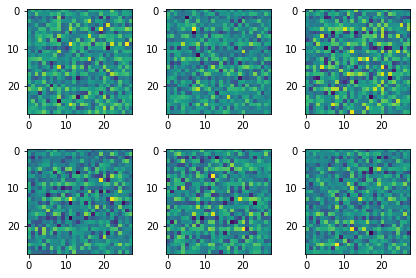

In [84]:
model =GAN()
model.plot_img()

In [85]:
trainer = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
trainer.fit(model,dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [86]:
model.on_epoch_end()